# Imports and Setup

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Set visualization style
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

# Data Loading and Preparation

In [18]:
# 1. Load block info and price data
blocks_df = pd.read_csv("17000000to17249999_Block_Info.csv")
price_df = pd.read_csv("ETH-USD.csv")

# 2. Load & concatenate all transaction shards
tx_files = ["tx_a_170.csv", "tx_a_172.csv", "tx_a_175.csv", "tx_a_177.csv"]
tx_df = pd.concat([pd.read_csv(f) for f in tx_files], ignore_index=True)

# Convert block timestamps (seconds → datetime)
blocks_df['timestamp'] = pd.to_datetime(blocks_df['timestamp'], unit='s')

# Merge block info with transaction features on blockNumber
merged_df = blocks_df.merge(
    tx_df,
    on='blockNumber',
    how='left'
)

<ipython-input-18-c9133bed22d2>:2: DtypeWarning: Columns (16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  blocks_df = pd.read_csv("17000000to17249999_Block_Info.csv")


# Data Aggregation and Feature Engineering

In [19]:
# Aggregate to daily-level features
merged_df.set_index('timestamp', inplace=True)

daily_df = merged_df.resample('D').agg({
    'difficulty': 'mean',
    'gasLimit': 'mean',
    'gasUsed': 'mean',
    'tx_count': 'sum',
    'total_gasUsed': 'sum',
    'avg_gasPrice': 'mean',
    'total_value': 'sum',
    'avg_baseFeePerGas': 'mean',
    'gas_utilization_ratio': 'mean',
    'unique_senders': 'sum',
    'unique_recipients': 'sum',
    'avg_maxFeePerGas': 'mean',
    'avg_maxPriorityFeePerGas': 'mean'
}).reset_index().rename(columns={'timestamp': 'date'})

# Prepare the price DataFrame for merging
price_df['date'] = pd.to_datetime(price_df['Date']).dt.date
daily_df['date'] = daily_df['date'].dt.date

# Merge with price data
final_df = pd.merge(daily_df, price_df, on='date', how='inner')

# Feature Engineering
final_df['daily_tx_per_block'] = final_df['tx_count'] / (final_df['gasUsed'] / final_df['gasLimit'])
final_df['eth_volume'] = final_df['Volume'] / final_df['Close']  # ETH volume in ETH terms
final_df['fee_to_reward_ratio'] = final_df['avg_gasPrice'] / final_df['avg_maxPriorityFeePerGas']
final_df['price_change'] = final_df['Close'].pct_change() * 100  # Daily percentage price change
final_df['price_volatility'] = final_df['High'] - final_df['Low']  # Daily price range

# Create target variable - price 7 days in the future
final_df['future_price_7d'] = final_df['Close'].shift(-7)
final_df.dropna(inplace=True)  # Remove rows without future price

# Convert date to datetime and set as index
final_df['date'] = pd.to_datetime(final_df['date'])
final_df.set_index('date', inplace=True)

# Data Visualization

## Correlation Heatmap

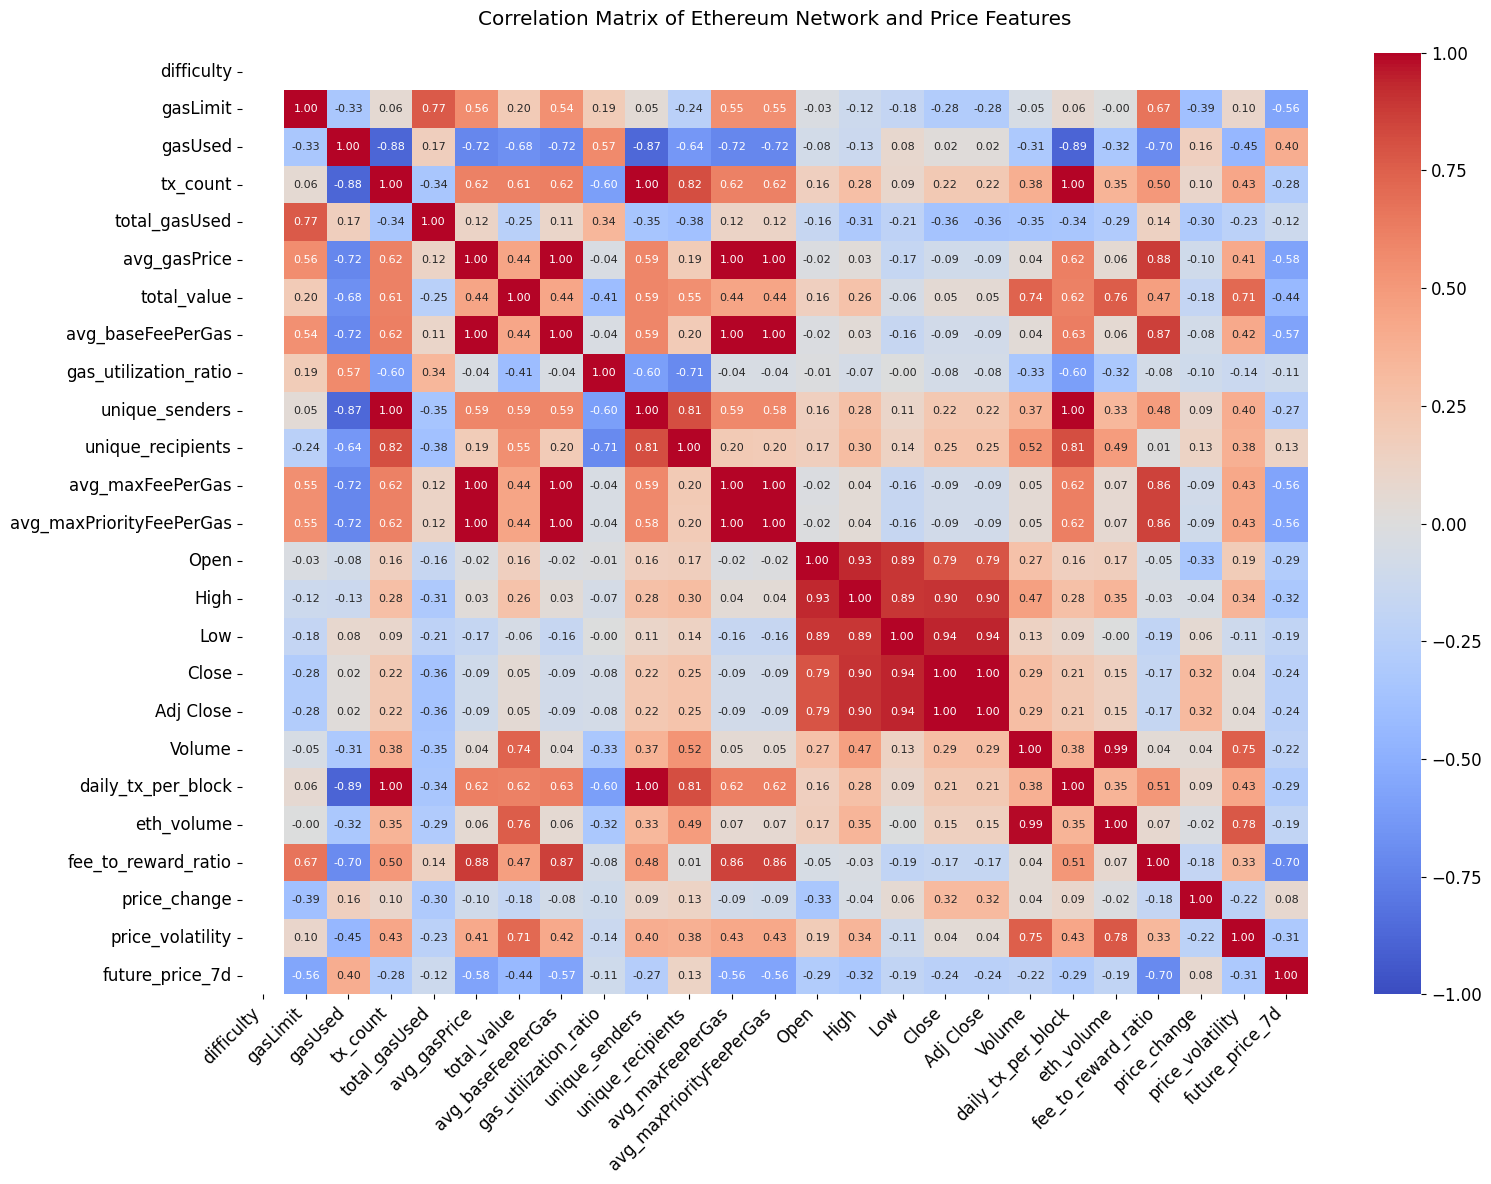

In [20]:
plt.figure(figsize=(16, 12))
corr_matrix = final_df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            annot_kws={"size": 8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Ethereum Network and Price Features', pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Time Series Plots

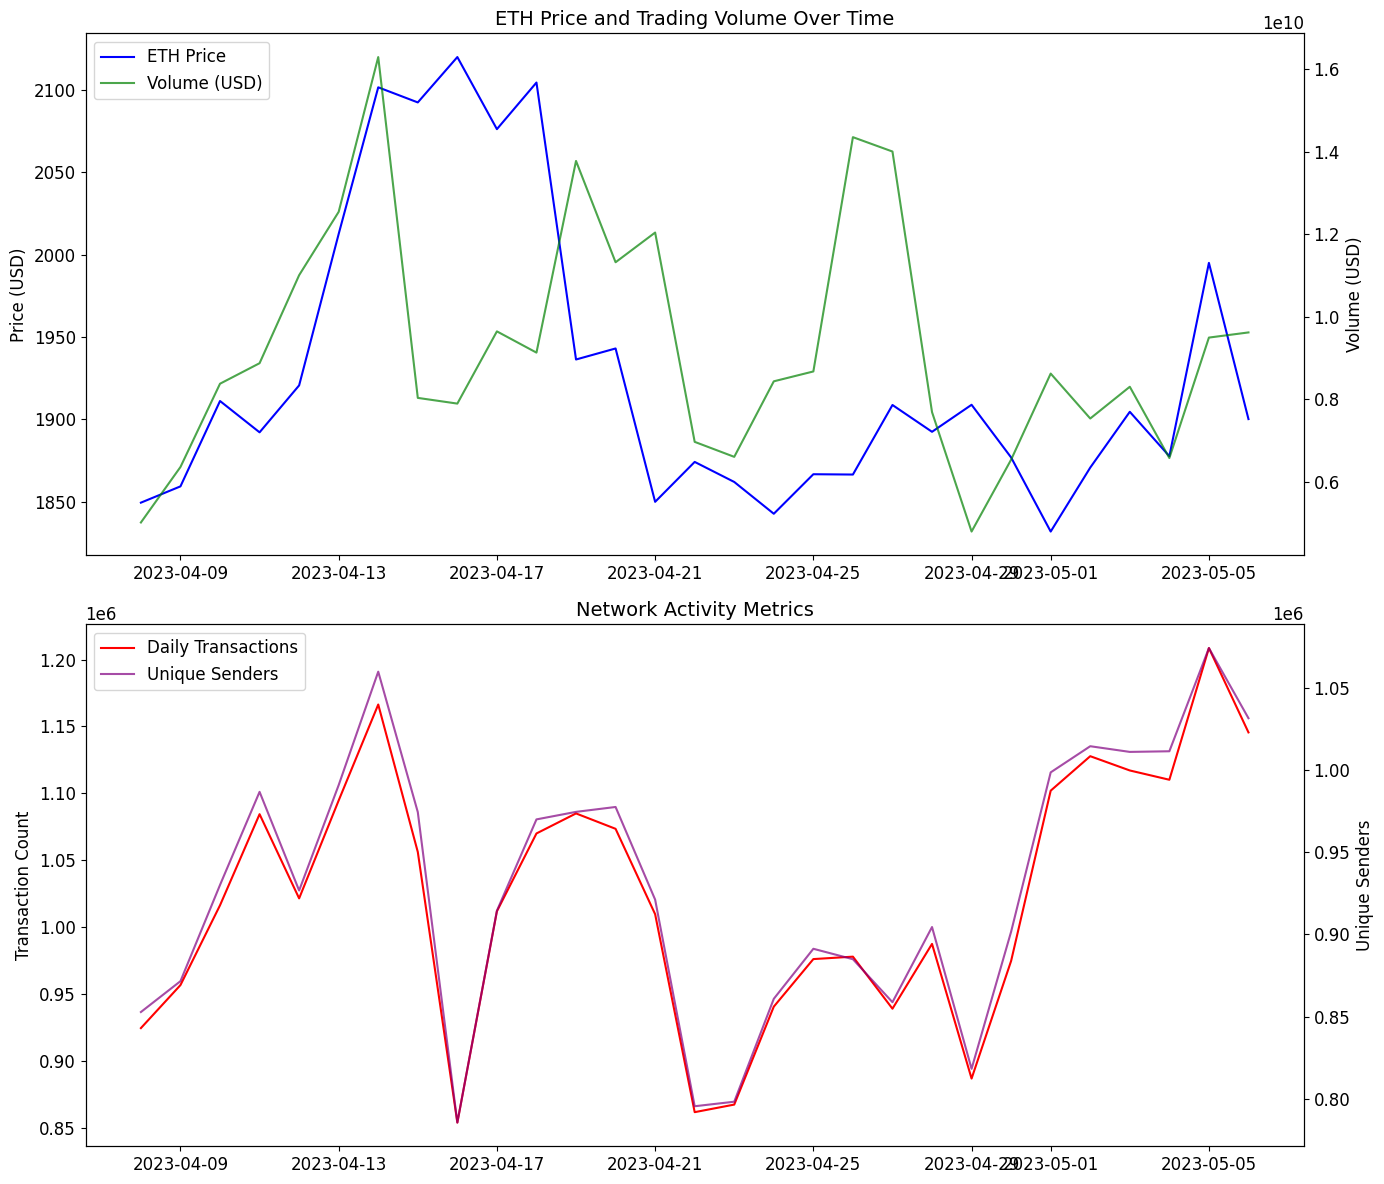

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Price and Volume
ax1.plot(final_df.index, final_df['Close'], label='ETH Price', color='blue')
ax1.set_ylabel('Price (USD)', fontsize=12)
ax1_twin = ax1.twinx()
ax1_twin.plot(final_df.index, final_df['Volume'], label='Volume (USD)', color='green', alpha=0.7)
ax1_twin.set_ylabel('Volume (USD)', fontsize=12)
ax1.set_title('ETH Price and Trading Volume Over Time', fontsize=14)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Network Activity
ax2.plot(final_df.index, final_df['tx_count'], label='Daily Transactions', color='red')
ax2.set_ylabel('Transaction Count', fontsize=12)
ax2_twin = ax2.twinx()
ax2_twin.plot(final_df.index, final_df['unique_senders'], label='Unique Senders', color='purple', alpha=0.7)
ax2_twin.set_ylabel('Unique Senders', fontsize=12)
ax2.set_title('Network Activity Metrics', fontsize=14)
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# PCA Analysis

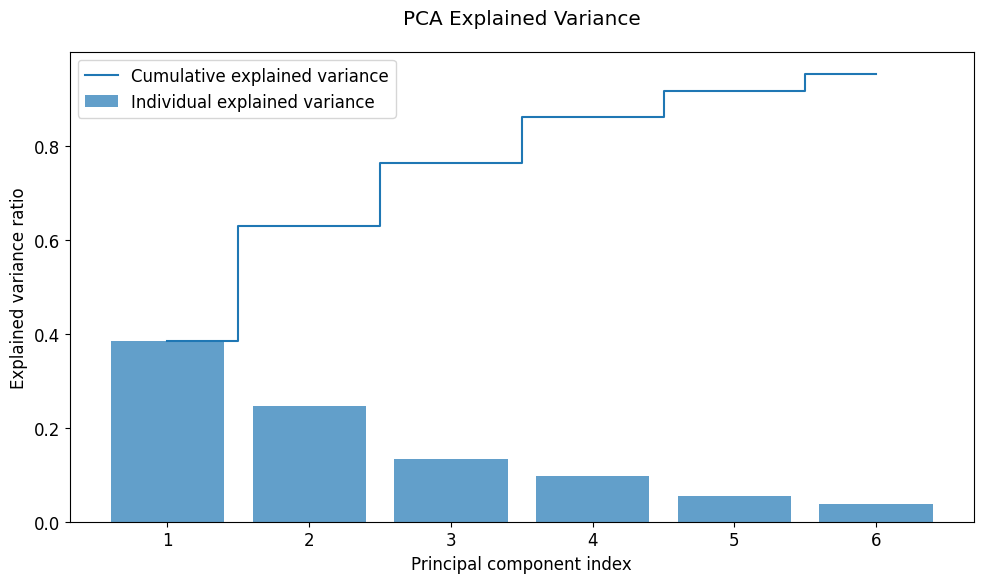

In [22]:
# Select numerical features (excluding target and date)
numerical_features = [col for col in final_df.columns if final_df[col].dtype in ['int64', 'float64']]
numerical_features.remove('future_price_7d')

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df[numerical_features])

# Perform PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
principal_components = pca.fit_transform(scaled_data)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_,
        alpha=0.7, align='center', label='Individual explained variance')
plt.step(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_),
         where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('PCA Explained Variance', pad=20)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Random Forest Model

In [23]:
# Define features and target
X = final_df[numerical_features]
y = final_df['future_price_7d']

# Time-based train-test split (80-20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train Random Forest
rf_model = RandomForestRegressor(n_estimators=200, random_state=42,
                               max_depth=10, min_samples_split=5)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate performance
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest Performance:")
print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")


Random Forest Performance:
MAE: 75.22
RMSE: 79.99


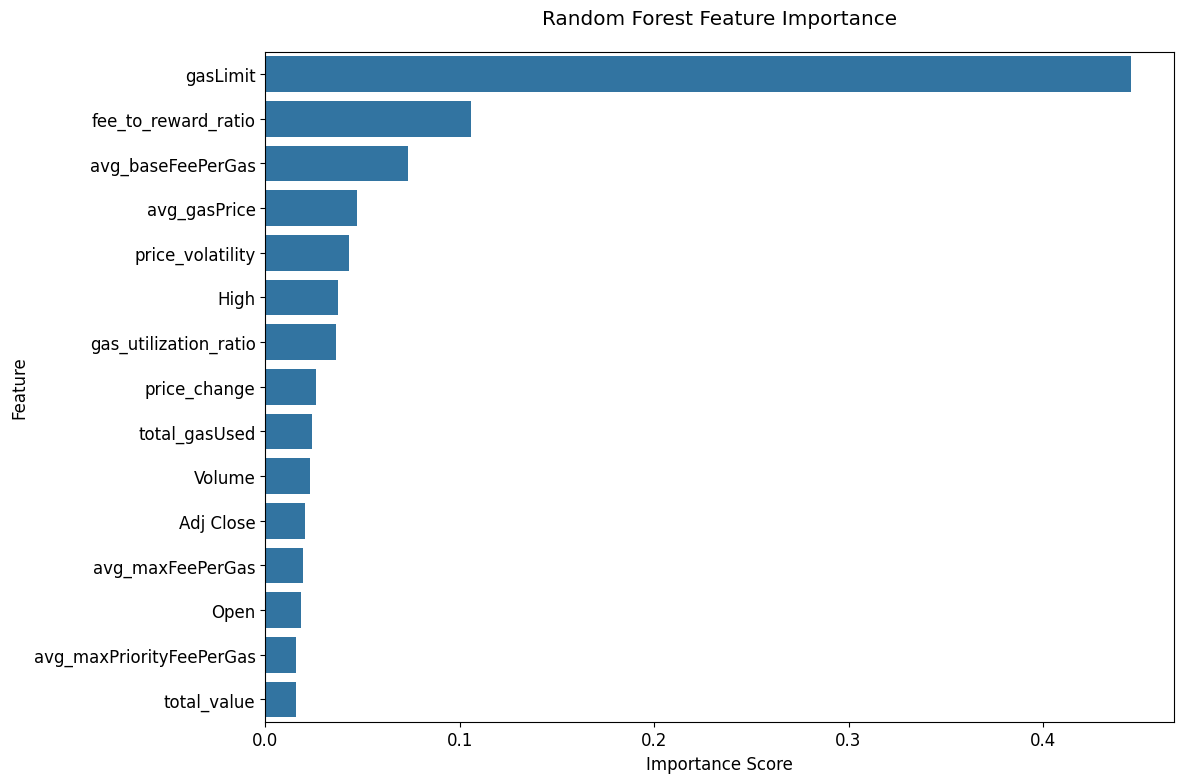

In [24]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': numerical_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Random Forest Feature Importance', pad=20)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


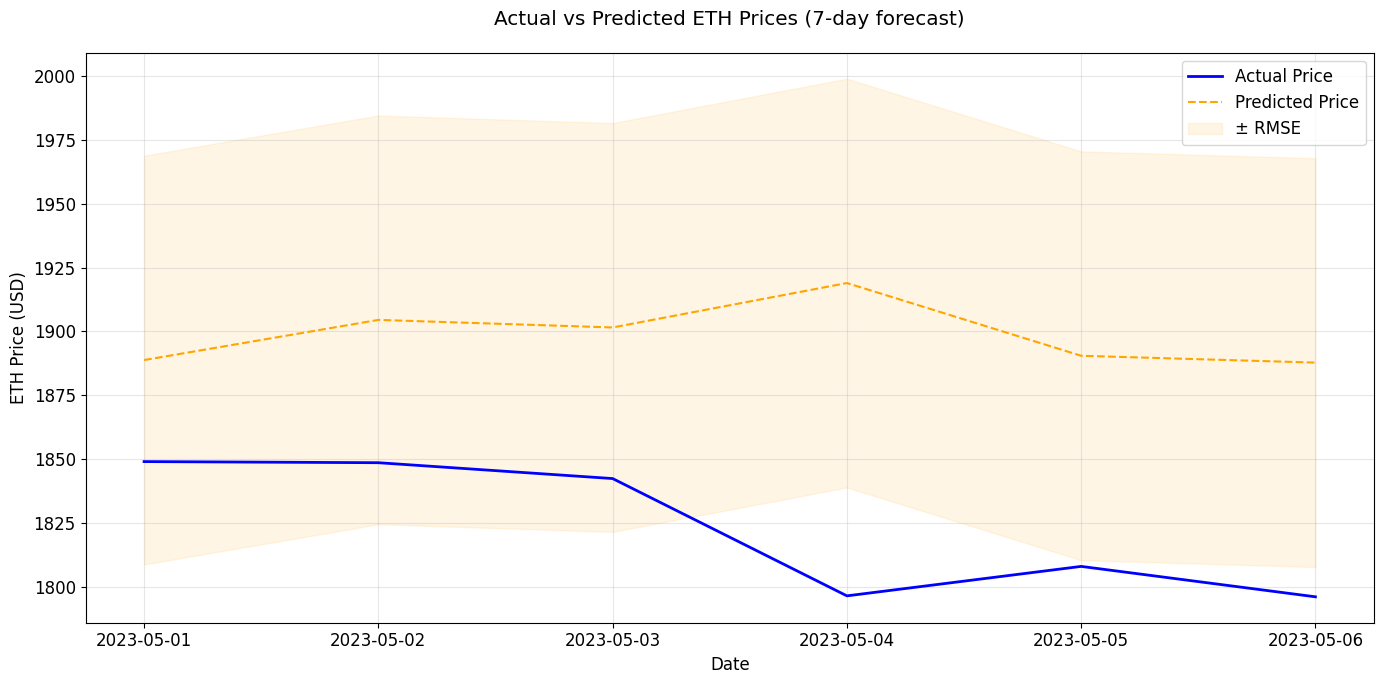

In [25]:
# Plot actual vs predicted
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Price', color='blue', linewidth=2)
plt.plot(y_test.index, y_pred_rf, label='Predicted Price', color='orange', linestyle='--')
plt.fill_between(y_test.index,
                y_pred_rf - rf_rmse,
                y_pred_rf + rf_rmse,
                color='orange', alpha=0.1, label='± RMSE')
plt.title('Actual vs Predicted ETH Prices (7-day forecast)', pad=20)
plt.xlabel('Date')
plt.ylabel('ETH Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Validator Behavior Analysis

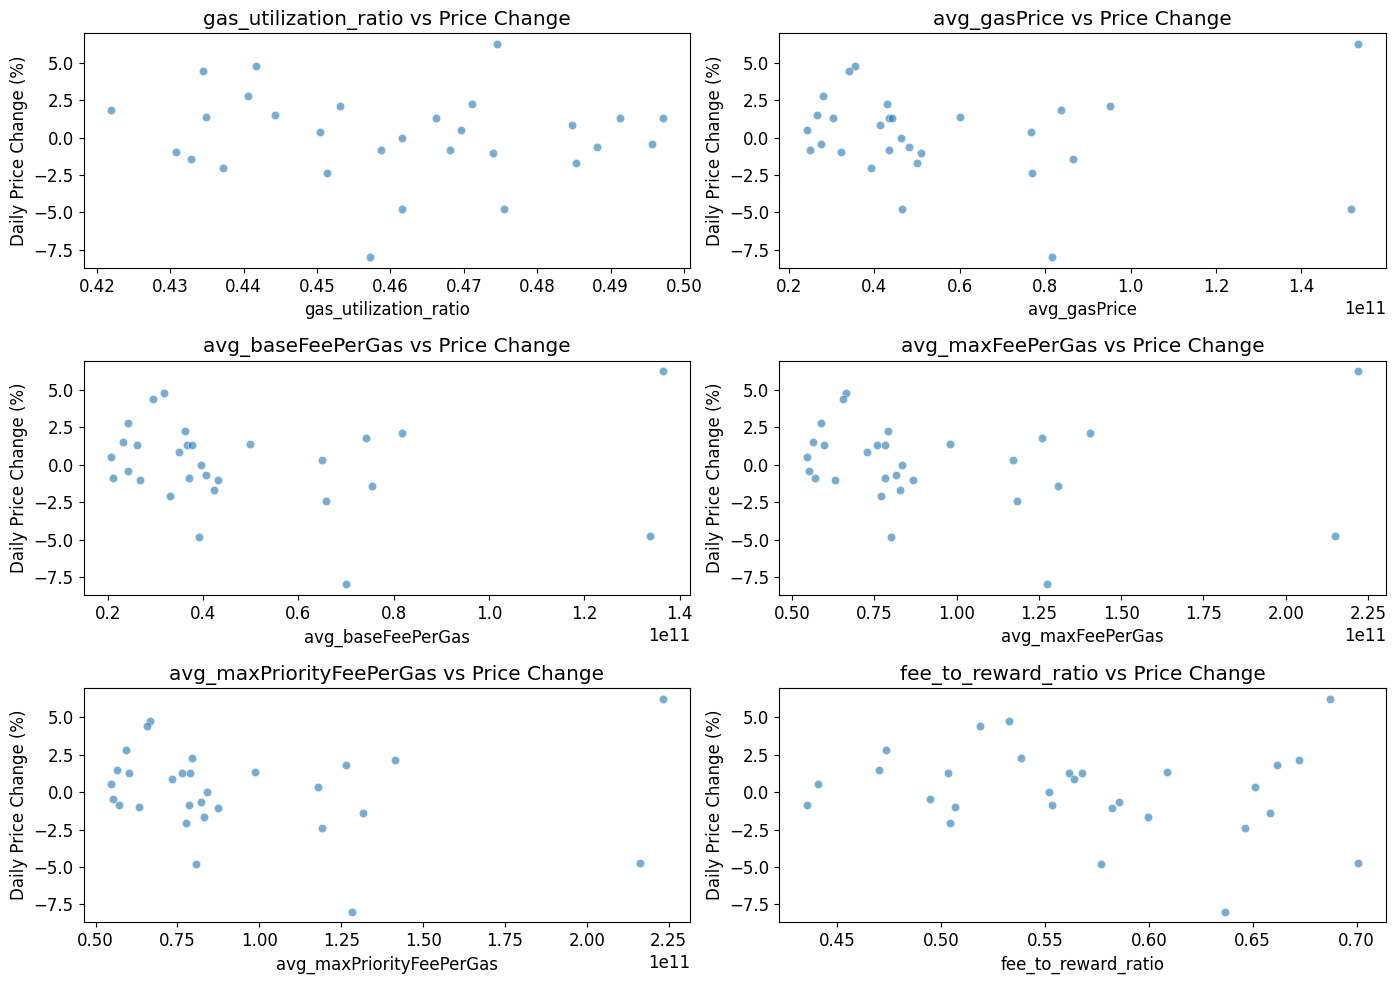

In [26]:
validator_metrics = ['gas_utilization_ratio', 'avg_gasPrice', 'avg_baseFeePerGas',
                    'avg_maxFeePerGas', 'avg_maxPriorityFeePerGas', 'fee_to_reward_ratio']

# Visualization: Validator metrics vs price change
plt.figure(figsize=(14, 10))
for i, metric in enumerate(validator_metrics, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=final_df[metric], y=final_df['price_change'], alpha=0.6)
    plt.title(f'{metric} vs Price Change')
    plt.xlabel(metric)
    plt.ylabel('Daily Price Change (%)')
plt.tight_layout()
plt.show()

# Cross-correlation analysis
lags = range(0, 15)  # Look at correlations up to 14 days lag
correlations = {metric: [] for metric in validator_metrics}

for metric in validator_metrics:
    for lag in lags:
        # Create aligned series by dropping NAs from both series
        shifted = final_df[metric].shift(lag)
        aligned_df = pd.DataFrame({
            'metric': shifted,
            'price_change': final_df['price_change']
        }).dropna()

        # Calculate correlation only if we have enough data points
        if len(aligned_df) > 5:  # Minimum threshold for meaningful correlation
            corr = np.corrcoef(aligned_df['metric'], aligned_df['price_change'])[0, 1]
            correlations[metric].append(corr)
        else:
            correlations[metric].append(np.nan)


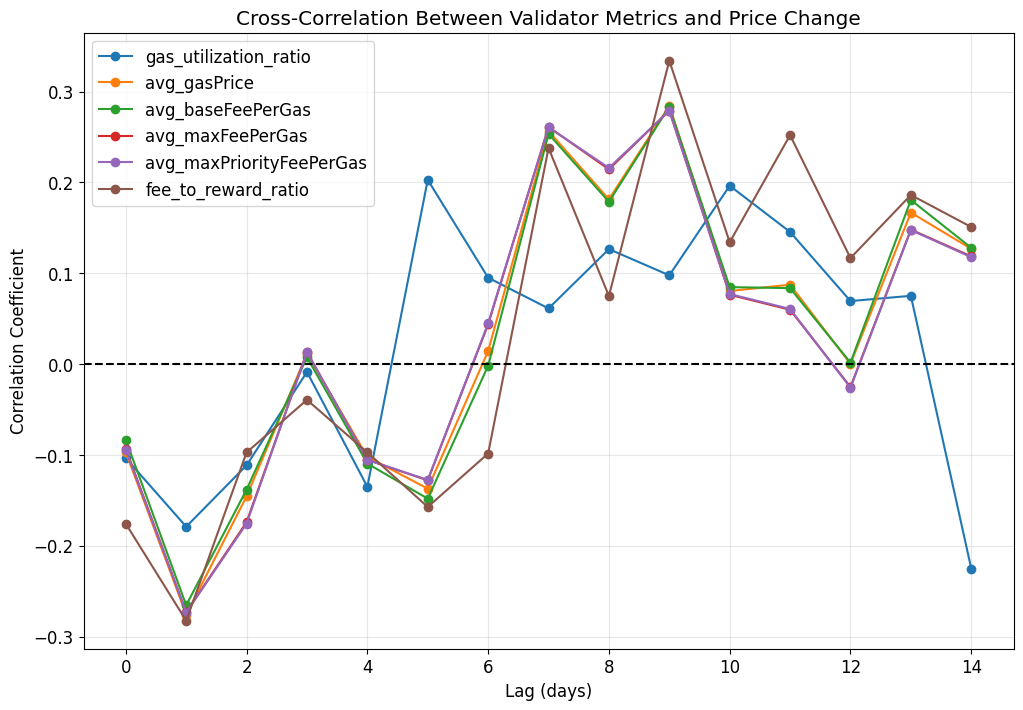

In [27]:
# Plot cross-correlations
plt.figure(figsize=(12, 8))
for metric in validator_metrics:
    plt.plot(lags, correlations[metric], label=metric, marker='o')
plt.axhline(0, color='black', linestyle='--')
plt.title('Cross-Correlation Between Validator Metrics and Price Change')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Neural Network

In [7]:
# Select features and target
features = ['gasUsed', 'tx_count', 'avg_gasPrice', 'total_value',
           'gas_utilization_ratio', 'unique_senders', 'Close', 'Volume',
           'daily_tx_per_block', 'fee_to_reward_ratio', 'price_volatility']
target = 'future_price_7d'

X = final_df[features]
y = final_df[target]

# Train-test split (time-based)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Linear activation for regression
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 4010917.0000 - mae: 2000.0691 - val_loss: 3431436.0000 - val_mae: 1852.3888
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 4009489.0000 - mae: 1999.7224 - val_loss: 3431110.5000 - val_mae: 1852.3011
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 4009734.5000 - mae: 1999.7760 - val_loss: 3430784.0000 - val_mae: 1852.2134
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step - loss: 4009550.0000 - mae: 1999.7273 - val_loss: 3430457.5000 - val_mae: 1852.1254
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 4008676.5000 - mae: 1999.4862 - val_loss: 3430160.5000 - val_mae: 1852.0454
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 4008095.5000 - mae: 1999.3545 - val_loss: 3429873.7500 - val_mae: 1851.9680
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 4008946.0000 - mae: 1999.5771 - val_loss: 3429586.0000 - val_mae: 1851.8904
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 40

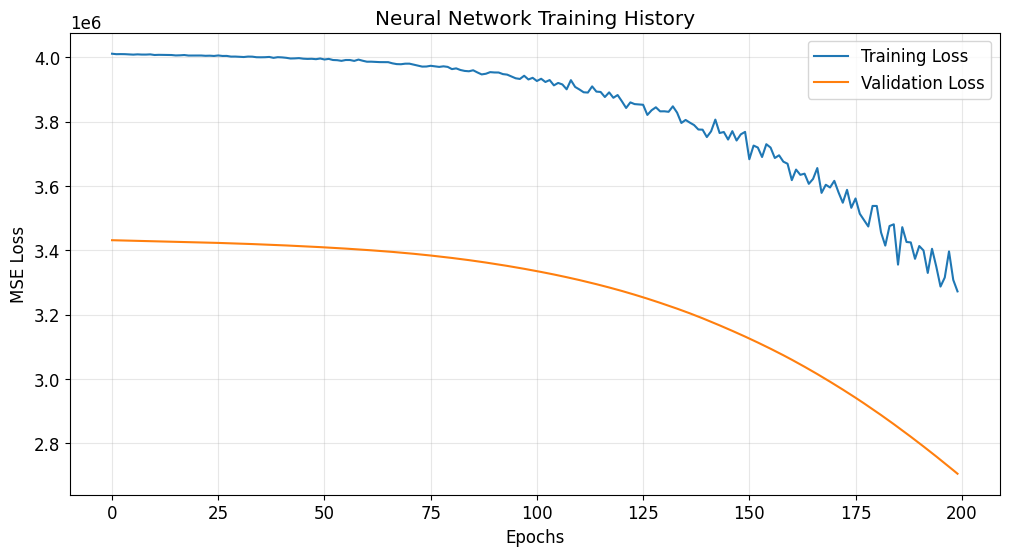

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Training History')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
y_pred_nn = model.predict(X_test_scaled).flatten()

nn_mae = mean_absolute_error(y_test, y_pred_nn)
nn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))

print(f"Neural Network Performance:")
print(f"MAE: {nn_mae:.2f}")
print(f"RMSE: {nn_rmse:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Neural Network Performance:
MAE: 1643.10
RMSE: 1644.95


# LSTM Model Implementation

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0921 - val_loss: 0.0087
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0810 - val_loss: 0.0061
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0693 - val_loss: 0.0056
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0461 - val_loss: 0.0070
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0422 - val_loss: 0.0104
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0354 - val_loss: 0.0159
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0271 - val_loss: 0.0235
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0241 - val_loss: 0.0336
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0207 - val_loss: 0.0457
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0157 - val_loss: 0.0592
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0188 - val_loss: 0.0718
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0163 - val_loss: 0.0

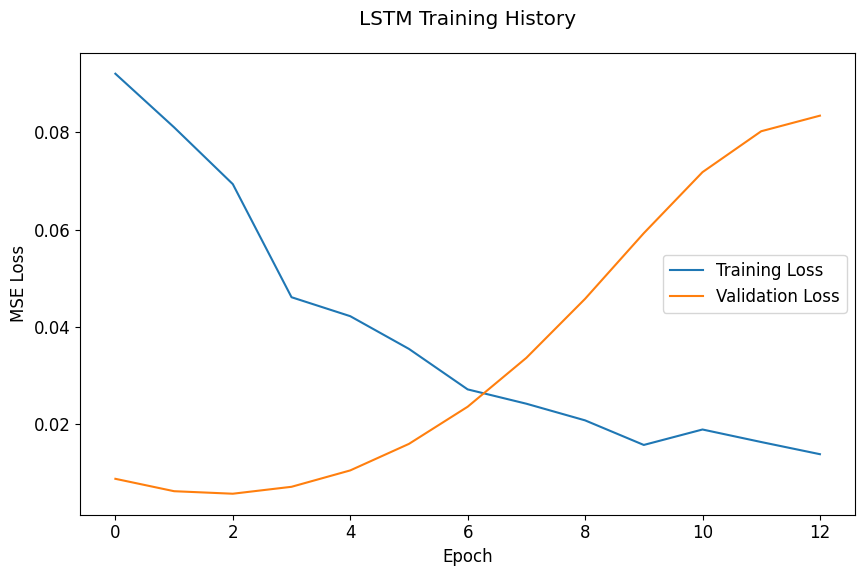

In [28]:
# Select features and target
features = ['gasUsed', 'tx_count', 'avg_gasPrice', 'total_value',
            'gas_utilization_ratio', 'unique_senders', 'Close', 'Volume',
            'daily_tx_per_block', 'fee_to_reward_ratio', 'price_volatility']
target = 'future_price_7d'

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_df[features + [target]])

# Create sequences for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, :-1])  # All features except last column (target)
        y.append(data[i+n_steps, -1])     # Target value
    return np.array(X), np.array(y)

n_steps = 7  # Using 7 days of history
X, y = create_sequences(scaled_data, n_steps)

# Train-test split (80-20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(n_steps, len(features)), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train LSTM
history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History', pad=20)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [29]:
# Make predictions
y_pred_lstm = lstm_model.predict(X_test)

# Inverse transform predictions and actual values
y_test_actual = y_test * (final_df[target].max() - final_df[target].min()) + final_df[target].min()
y_pred_lstm_actual = y_pred_lstm * (final_df[target].max() - final_df[target].min()) + final_df[target].min()

# Evaluate LSTM performance
lstm_mae = mean_absolute_error(y_test_actual, y_pred_lstm_actual)
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_lstm_actual))

print(f"\nLSTM Performance:")
print(f"MAE: {lstm_mae:.2f}")
print(f"RMSE: {lstm_rmse:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step

LSTM Performance:
MAE: 23.47
RMSE: 24.27


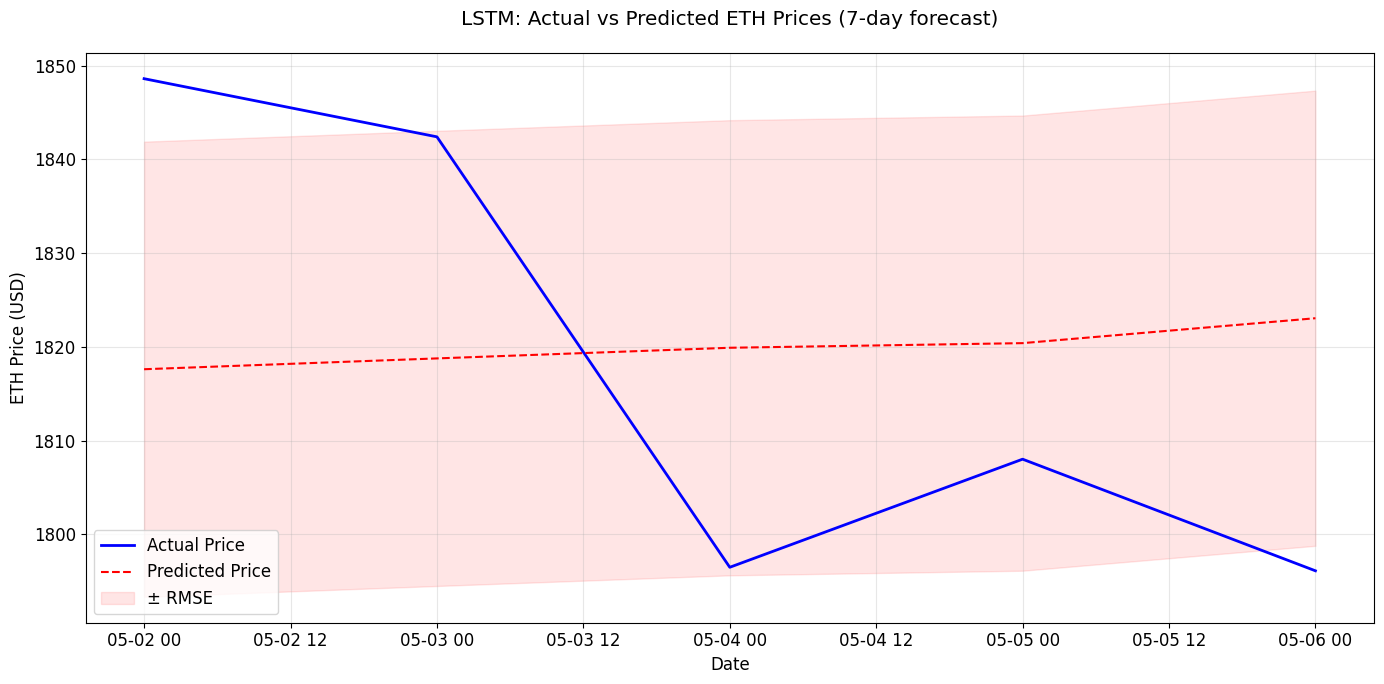

In [30]:
# Plot actual vs predicted for LSTM
test_dates = final_df.index[split_idx + n_steps:split_idx + n_steps + len(y_test)]

plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_actual, label='Actual Price', color='blue', linewidth=2)
plt.plot(test_dates, y_pred_lstm_actual, label='Predicted Price', color='red', linestyle='--')
plt.fill_between(test_dates,
                y_pred_lstm_actual.flatten() - lstm_rmse,
                y_pred_lstm_actual.flatten() + lstm_rmse,
                color='red', alpha=0.1, label='± RMSE')
plt.title('LSTM: Actual vs Predicted ETH Prices (7-day forecast)', pad=20)
plt.xlabel('Date')
plt.ylabel('ETH Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Model Comparison

In [32]:
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'LSTM', 'Neural Network'],
    'MAE': [rf_mae, lstm_mae,  nn_mae],
    'RMSE': [rf_rmse, lstm_rmse,  nn_rmse]
}).set_index('Model')

print("\nModel Performance Comparison:")
print(model_comparison)


Model Performance Comparison:
                        MAE         RMSE
Model                                   
Random Forest     75.220438    79.990512
LSTM              23.470532    24.273381
Neural Network  1643.100418  1644.946746
